# Load packages and help functions

In [1]:
# Add local repository to python path -> allows for importing here
#import sys
#sys.path.append('/COMBINE')

# plotting package
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (9, 6)  # Default plot size
import seaborn as sns
sns.set(font_scale=2)

# Scientific packages
import numpy as np
import salem
import glob
import os
import oggm

# Constants
from oggm import cfg
cfg.initialize()

# OGGM models
from oggm.core.massbalance import LinearMassBalance
from oggm.core.flowline import FluxBasedModel as oggm_FluxModel
from oggm.core.flowline import RectangularBedFlowline as oggm_flowline
from oggm.core.flowline import ParabolicBedFlowline as oggm_para_flowline
from oggm.core.flowline import TrapezoidalBedFlowline as oggm_trap_flowline

# MUSCLsuperbee model
from MUSCL.MUSCL_flowline import MUSCLSuperBeeModel

# COMBINE models
from combine.core.flowline_adapted import RectangularBedDiffusiveFlowlineModel as combine_DiffusiveFlowlineModel
from combine.core.flowline_adapted import FluxBasedModel as combine_FluxFlowlineModel
from combine.core.flowline_adapted import RectangularBedFlowline as combine_flowline
from combine.core.flowline_adapted import ParabolicBedFlowline as combine_para_flowline
from combine.core.flowline_adapted import TrapezoidalBedFlowline as combine_trap_flowline

import torch

2020-06-26 16:39:50: oggm.cfg: Using configuration file: /home/patrick/miniconda3/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg
2020-06-26 16:39:50: oggm.cfg: Multiprocessing switched ON according to the parameter file.
2020-06-26 16:39:50: oggm.cfg: Multiprocessing: using all available processors (N=4)
2020-06-26 16:39:50: oggm.utils: Checking the download verification file checksum...


In [2]:
import timeit
from functools import partial


# function to time function execution time
def time_fct(model_run_fct, year):
    timeit_fct = partial(timeit.timeit, number=1)
    return timeit_fct(partial(model_run_fct, year))


# function to compare volume
def compare_vol(models): 
    header_format ="{:>15}" * (len(models) + 1)

    names = []
    for model in models:
        names.append(model.name)
    print(header_format.format("", *names))

    data = [ [ 0 for y in range(len(models)) ] 
             for x in range(len(models)) ] 
    for row, model_row in enumerate(models):
        for col, model_col in enumerate(models):
            data[col][row] = model_row.fls[-1].volume_km3 - model_col.fls[-1].volume_km3

    row_format = "{:>15}" + ("{:15.2E}" * len(models))
    for name, row in zip(names, data):
        print(row_format.format(name, *row))

# Test dynamic Model in idealized setting

## Define simple linear glacier bed with constant width

In [3]:
# number of steps from bottem to top of glacier
nx = 200

# model grid spacing in m
map_dx = 100

# distance along glacier (x-axis of glacier profil plot) in km
distance_along_glacier = np.linspace(0, nx, nx) * map_dx * 1e-3

# glacier top height
glacier_top_height = 4000

# glacier bottom height
glacier_bottom_height = 0

# define linear glacier bed with zero ice thickness
bed_h = np.linspace(glacier_top_height, 0, nx)
surface_h = bed_h

# define width, so glacier bed could be created when plot is created (after creation model is ready)
widths = np.zeros(nx) + 4.
#widths = np.array([(-2 / nx * x + 2.5) * 2 for x in np.arange(nx)])

## define flowlines

In [4]:
oggm_fl = oggm_flowline(surface_h=surface_h, bed_h=bed_h,
                        widths=widths/map_dx, map_dx=map_dx)

combine_fl = combine_flowline(surface_h=surface_h, bed_h=bed_h,
                              widths=widths/map_dx, map_dx=map_dx, torch_type=torch.double)

## Define linear constant mass balance model

In [5]:
ELA = 3000
mb_gradient = 4

mb_model = LinearMassBalance(ELA, grad=mb_gradient)

## Define actual models

In [6]:
# initialize the actual model
oggm_model = oggm_FluxModel(oggm_fl, mb_model=mb_model, y0=0.)

muscl_model = MUSCLSuperBeeModel(oggm_fl, mb_model=mb_model, y0=0.)

# combine_diff_model = combine_DiffusiveFlowlineModel(combine_fl, mb_model=mb_model, y0=0.)
combine_flux_model = combine_FluxFlowlineModel(combine_fl, mb_model=mb_model, y0=0.)
#combine_flux_model_adapted = combine_FluxFlowlineModel_adapted(combine_fl, mb_model=mb_model, y0=0.)

functions to time Model runs

In [7]:
import timeit
from functools import partial

# function to time function execution time
def time_fct(model_run_fct, year):
    timeit_fct = partial(timeit.timeit, number=1)
    return timeit_fct(partial(model_run_fct, year))

In [8]:
def oggm_run(year):
    oggm_model.run_until(year)

def muscl_run(year):
    muscl_model.run_until(year)

def combine_diff_run(year):
    combine_diff_model.run_until(year)

def combine_flux_run(year):
    combine_flux_model.run_until(year)

def combine_flux_adapted_run(year):
    combine_flux_model_adapted.run_until(year)

## Run all models for 200 years

In [9]:
years = 200

print('OGGM: {:.2f} s\n'.format(time_fct(oggm_run, years)) +
      'MUSCL: {:.2f} s\n'.format(time_fct(muscl_run, years))+
      #'COMBINE Diff:  {:.2f} s, Iterations: {:d}\n'.format(time_fct(combine_diff_run, years), 
      #                                                   combine_diff_model.iterations) +
      'COMBINE Flux:  {:.2f} s, Iterations: {:d}\n'.format(time_fct(combine_flux_run, years), 
                                                         combine_flux_model.iterations))
      #'COMBINE Flux adapted:  {:.2f} s, Iterations: {:d}'.format(time_fct(combine_flux_adapted_run, years), 
      #                                                   combine_flux_model_adapted.iterations))

OGGM: 1.16 s
MUSCL: 2.26 s
COMBINE Flux:  3.88 s, Iterations: 9120



## Compare outcome

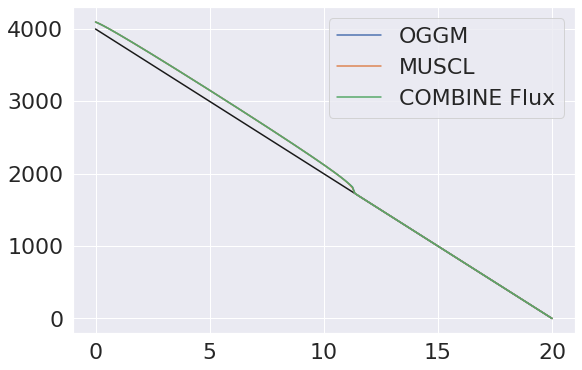

In [10]:
# Plot the final result:
plt.plot(distance_along_glacier, bed_h, 'k-')
plt.plot(distance_along_glacier, oggm_model.fls[-1].surface_h, label='OGGM')
plt.plot(distance_along_glacier, muscl_model.fls[-1].surface_h, label='MUSCL')
# plt.plot(distance_along_glacier, combine_diff_model.fls[-1].surface_h, label='COMBINE Diff')
plt.plot(distance_along_glacier, combine_flux_model.fls[-1].surface_h, label='COMBINE Flux')
#plt.plot(distance_along_glacier, combine_flux_model_adapted.fls[-1].surface_h, label='COMBINE Flux adapted')
plt.legend()

In [11]:
# function to compare volume
def compare_vol(models): 
    header_format ="{:>15}" * (len(models) + 1)

    names = []
    for model in models:
        names.append(model.name)
    print(header_format.format("", *names))

    data = [ [ 0 for y in range(len(models)) ] 
             for x in range(len(models)) ] 
    for row, model_row in enumerate(models):
        for col, model_col in enumerate(models):
            data[col][row] = model_row.fls[-1].volume_km3 - model_col.fls[-1].volume_km3

    row_format = "{:>15}" + ("{:15.2E}" * len(models))
    for name, row in zip(names, data):
        print(row_format.format(name, *row))

In [12]:
oggm_model.name = 'OGGM'
muscl_model.name = 'MUSCL'
# combine_diff_model.name = 'COMBINE Diff'
combine_flux_model.name = 'COMBINE Flux'
#combine_flux_model_adapted.name = 'COMBINE Flux v2'
compare_vol([oggm_model, muscl_model, combine_flux_model])

                          OGGM          MUSCL   COMBINE Flux
           OGGM       0.00E+00      -9.24E-06      -2.60E-18
          MUSCL       9.24E-06       0.00E+00       9.24E-06
   COMBINE Flux       2.60E-18      -9.24E-06       0.00E+00


# Test dynamic Model on more realistic topography

## Try with Hintereisferner

### If running the first time 

In [17]:
from oggm import workflow, utils

In [18]:
cfg.PATHS['working_dir'] = 'Hintereisferner_test'#utils.gettempdir(dirname='Hintereisferner_test', reset=True)
cfg.PATHS['working_dir']

'Hintereisferner_test'

In [19]:
rgi_ids = ['RGI60-11.00897']

In [20]:
gdirs = workflow.init_glacier_regions(rgi_ids, from_prepro_level=2, prepro_border=80)

2020-06-18 10:10:44: oggm.workflow: init_glacier_regions from prepro level 2 on 1 glaciers.
2020-06-18 10:10:44: oggm.utils: Downloading https://cluster.klima.uni-bremen.de/data/downloads.sha256.xz to /home/patrick/.oggm/downloads.sha256.xz...
2020-06-18 10:11:02: oggm.utils: Done downloading.
2020-06-18 10:11:02: oggm.utils: /home/patrick/.oggm/downloads.sha256.xz changed or invalid, deleting.
2020-06-18 10:11:02: oggm.utils: Downloading and verifiying checksums failed.
2020-06-18 10:11:02: oggm.workflow: Execute entity task gdir_from_prepro on 1 glaciers
2020-06-18 10:11:03: oggm.workflow: Multiprocessing: using all available processors (N=4)


In [21]:
from oggm import tasks

In [22]:
workflow.execute_entity_task(tasks.glacier_masks, gdirs);

2020-06-18 10:11:28: oggm.workflow: Execute entity task glacier_masks on 1 glaciers


In [23]:
# only calculate one flowline
cfg.PARAMS['use_multiple_flowlines'] = False

list_talks = [
         tasks.compute_centerlines,
         tasks.initialize_flowlines,
         tasks.compute_downstream_line,
         ]
for task in list_talks:
    # The order matters!
    workflow.execute_entity_task(task, gdirs)

2020-06-18 10:11:29: oggm.workflow: Execute entity task compute_centerlines on 1 glaciers
2020-06-18 10:11:29: oggm.workflow: Multiprocessing: using all available processors (N=4)
2020-06-18 10:11:36: oggm.workflow: Execute entity task initialize_flowlines on 1 glaciers
2020-06-18 10:11:36: oggm.workflow: Execute entity task compute_downstream_line on 1 glaciers


In [24]:
from oggm import graphics

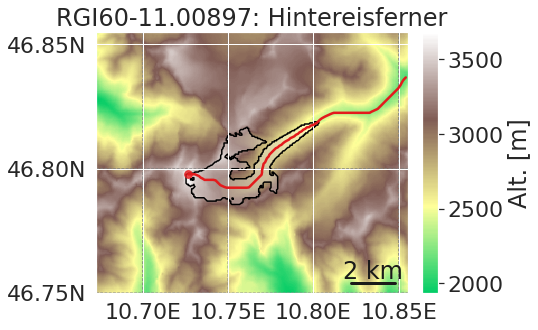

In [25]:
graphics.plot_centerlines(gdirs[0], figsize=(8, 7), use_flowlines=True, add_downstream=True)

In [26]:
list_talks = [
         tasks.catchment_area,
         tasks.catchment_width_geom,
         tasks.catchment_width_correction,
         tasks.compute_downstream_bedshape
         ]
for task in list_talks:
    # The order matters!
    workflow.execute_entity_task(task, gdirs)

2020-06-18 10:11:37: oggm.workflow: Execute entity task catchment_area on 1 glaciers
2020-06-18 10:11:37: oggm.workflow: Execute entity task catchment_width_geom on 1 glaciers
2020-06-18 10:11:38: oggm.workflow: Execute entity task catchment_width_correction on 1 glaciers
2020-06-18 10:11:38: oggm.workflow: Execute entity task compute_downstream_bedshape on 1 glaciers


In [27]:
workflow.execute_entity_task(tasks.local_t_star, gdirs);
workflow.execute_entity_task(tasks.mu_star_calibration, gdirs);

2020-06-18 10:11:38: oggm.workflow: Execute entity task local_t_star on 1 glaciers
2020-06-18 10:11:38: oggm.workflow: Execute entity task mu_star_calibration on 1 glaciers


In [28]:
list_talks = [
         tasks.prepare_for_inversion,  # This is a preprocessing task
         tasks.mass_conservation_inversion,  # This does the actual job
         tasks.filter_inversion_output  # This smoothes the thicknesses at the tongue a little
         ]
for task in list_talks:
    workflow.execute_entity_task(task, gdirs)

2020-06-18 10:11:38: oggm.workflow: Execute entity task prepare_for_inversion on 1 glaciers
2020-06-18 10:11:38: oggm.workflow: Execute entity task mass_conservation_inversion on 1 glaciers
2020-06-18 10:11:39: oggm.workflow: Execute entity task filter_inversion_output on 1 glaciers


In [29]:
# Convert the flowlines to a "glacier" for the ice dynamics module
workflow.execute_entity_task(tasks.init_present_time_glacier, gdirs);

2020-06-18 10:11:39: oggm.workflow: Execute entity task init_present_time_glacier on 1 glaciers


In [ ]:
gdir = gdirs[0]

### If already downloaded and preprocessed

In [13]:
cfg.PATHS['working_dir'] = 'Hintereisferner_test'
gdir = oggm.GlacierDirectory('RGI60-11.00897')

### Start of Experiments

In [14]:
fls = gdir.read_pickle('model_flowlines')

In [15]:
dx = fls[0].dx_meter
nx = fls[0].nx
distance_along_glacier = np.linspace(0, nx, nx) * dx * 1e-3

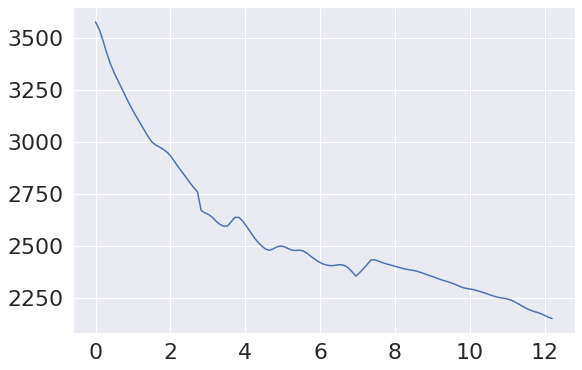

In [16]:
plt.plot(distance_along_glacier, fls[0].surface_h - fls[0].thick)

constant width

In [30]:
nx = fls[0].nx
map_dx = fls[0].dx_meter
bed_h = fls[0].surface_h - fls[0].thick
surface_h = bed_h
widths = np.zeros(nx) + 4.
distance_along_glacier = np.linspace(0, nx, nx) * map_dx * 1e-3

oggm_fl = oggm_flowline(surface_h=surface_h, bed_h=bed_h,
                        widths=widths/map_dx, map_dx=map_dx)

combine_fl = combine_flowline(surface_h=surface_h, bed_h=bed_h,
                              widths=widths/map_dx, map_dx=map_dx, torch_type=torch.double)

ELA = 2700
mb_gradient = 4

mb_model = LinearMassBalance(ELA, grad=mb_gradient)

oggm_model = oggm_FluxModel(oggm_fl, mb_model=mb_model, y0=0.)
muscl_model = MUSCLSuperBeeModel(oggm_fl, mb_model=mb_model, y0=0.)
# combine_diff_model = combine_DiffusiveFlowlineModel(combine_fl, mb_model=mb_model, y0=0.)
combine_flux_model = combine_FluxFlowlineModel(combine_fl, mb_model=mb_model, y0=0.)

years = 200

print('OGGM: {:.2f} s\n'.format(time_fct(oggm_run, years)) +
      'MUSCL: {:.2f} s\n'.format(time_fct(muscl_run, years))+
      #'COMBINE Diff:  {:.2f} s, Iterations: {:d}\n'.format(time_fct(combine_diff_run, years), 
      #                                                   combine_diff_model.iterations) +
      'COMBINE Flux:  {:.2f} s, Iterations: {:d}'.format(time_fct(combine_flux_run, years), 
                                                         combine_flux_model.iterations))

OGGM: 0.72 s
MUSCL: 2.07 s
COMBINE Flux:  3.05 s, Iterations: 6808


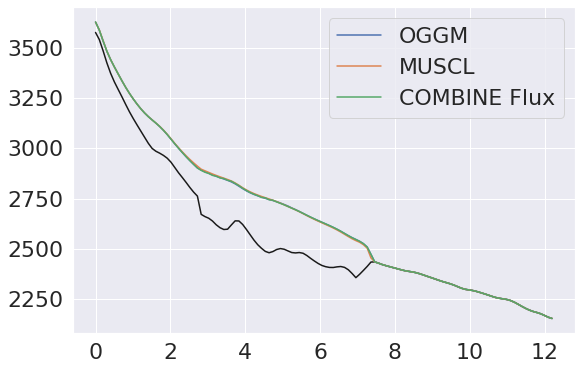

In [31]:
# Plot the final result:
plt.plot(distance_along_glacier, bed_h, 'k-')
plt.plot(distance_along_glacier, oggm_model.fls[-1].surface_h, label='OGGM')
plt.plot(distance_along_glacier, muscl_model.fls[-1].surface_h, label='MUSCL')
# plt.plot(distance_along_glacier, combine_diff_model.fls[-1].surface_h, label='COMBINE Diff')
plt.plot(distance_along_glacier, combine_flux_model.fls[-1].surface_h, label='COMBINE Flux')
plt.legend()

In [32]:
oggm_model.name = 'OGGM'
muscl_model.name = 'MUSCL'
#combine_diff_model.name = 'COMBINE Diff'
combine_flux_model.name = 'COMBINE Flux'
compare_vol([oggm_model, muscl_model, combine_flux_model])

                          OGGM          MUSCL   COMBINE Flux
           OGGM       0.00E+00       1.25E-05      -4.40E-07
          MUSCL      -1.25E-05       0.00E+00      -1.29E-05
   COMBINE Flux       4.40E-07       1.29E-05       0.00E+00


changing width

In [25]:
widths = fls[0].widths_m
# define a min width
widths = np.where(widths > 0, widths, 100)

oggm_fl = oggm_flowline(surface_h=surface_h, bed_h=bed_h,
                        widths=widths/map_dx, map_dx=map_dx)

combine_fl = combine_flowline(surface_h=surface_h, bed_h=bed_h,
                              widths=widths/map_dx, map_dx=map_dx, torch_type=torch.double)

ELA = 3000
mb_gradient = 4

mb_model = LinearMassBalance(ELA, grad=mb_gradient)

oggm_model = oggm_FluxModel(oggm_fl, mb_model=mb_model, y0=0.)
#combine_diff_model = combine_DiffusiveFlowlineModel(combine_fl, mb_model=mb_model, y0=0.)
combine_flux_model = combine_FluxFlowlineModel(combine_fl, mb_model=mb_model, y0=0.)
#combine_flux_model_adapted = combine_FluxFlowlineModel_adapted(combine_fl, mb_model=mb_model, y0=0.)

years = 200

print('OGGM: {:.2f} s\n'.format(time_fct(oggm_run, years)) +
      #'COMBINE Diff:  {:.2f} s, Iterations: {:d}\n'.format(time_fct(combine_diff_run, years), 
      #                                                   combine_diff_model.iterations) +
      'COMBINE Flux:  {:.2f} s, Iterations: {:d}\n'.format(time_fct(combine_flux_run, years), 
                                                         combine_flux_model.iterations))
      #'COMBINE Flux v2:  {:.2f} s, Iterations: {:d}\n'.format(time_fct(combine_flux_adapted_run, years), 
      #                                                   combine_flux_model_adapted.iterations))

OGGM: 0.50 s
COMBINE Flux:  1.88 s, Iterations: 4112



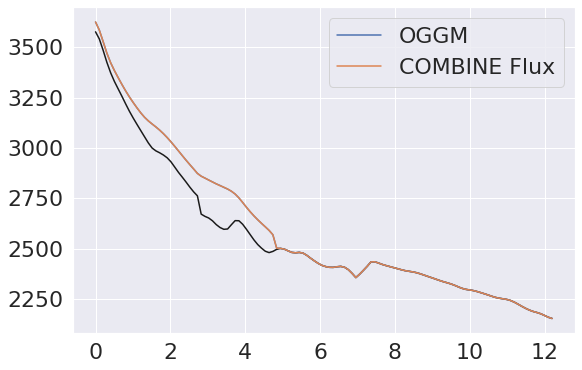

In [26]:
plt.plot(distance_along_glacier, bed_h, 'k-')
plt.plot(distance_along_glacier, oggm_model.fls[-1].surface_h, label='OGGM')
# plt.plot(distance_along_glacier, combine_diff_model.fls[-1].surface_h, label='COMBINE Diff')
plt.plot(distance_along_glacier, combine_flux_model.fls[-1].surface_h, label='COMBINE Flux')
#plt.plot(distance_along_glacier, combine_flux_model_adapted.fls[-1].surface_h, label='COMBINE Flux v2')
plt.legend()

In [27]:
oggm_model.name = 'OGGM'
# combine_diff_model.name = 'COMBINE Diff'
combine_flux_model.name = 'COMBINE Flux'
#combine_flux_model_adapted.name = 'COMBINE Flux v2'
compare_vol([oggm_model, combine_flux_model])

                          OGGM   COMBINE Flux
           OGGM       0.00E+00       2.54E-06
   COMBINE Flux      -2.54E-06       0.00E+00


# First guess GlapTop

In [39]:
from combine.core.first_guess import first_guess_flowline

# get flowline with OGGM bed
gdir = gdirs[0]
fls = gdir.read_pickle('model_flowlines')
dx = fls[0].dx_meter
nx = fls[0].nx
distance_along_glacier = np.linspace(0, nx, nx) * dx * 1e-3

# get ice flowline for GlapTop function
inv_fls = gdir.read_pickle('inversion_flowlines')
inv_fls_sfc = inv_fls[0].surface_h
inv_nx = inv_fls[0].nx
distance_along_inv_glacier = np.linspace(0, inv_nx, inv_nx) * dx * 1e-3

# calculate glacier bed
glaptop_bed = first_guess_flowline(inv_fls[0], inv_fls_sfc > 0, dx)

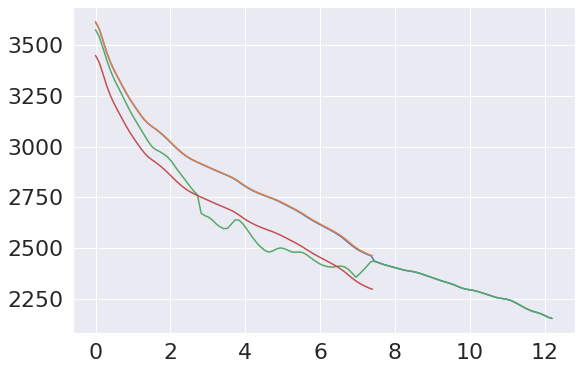

In [40]:
plt.plot(distance_along_glacier, fls[0].surface_h)
plt.plot(distance_along_inv_glacier, inv_fls_sfc)
plt.plot(distance_along_glacier, fls[0].surface_h - fls[0].thick)
plt.plot(distance_along_inv_glacier, glaptop_bed)

# Rectangular bed shape

## Hintereisferner bed with constant width

In [20]:
cfg.PATHS['working_dir'] = 'Hintereisferner_test'
gdir = oggm.GlacierDirectory('RGI60-11.00897')
fls = gdir.read_pickle('model_flowlines')
dx = fls[0].dx_meter
nx = fls[0].nx
distance_along_glacier = np.linspace(0, nx, nx) * dx * 1e-3
bed_h = fls[0].surface_h - fls[0].thick

surface_h = bed_h
widths = np.zeros(nx) + 1.

oggm_fl = oggm_flowline(surface_h=surface_h, bed_h=bed_h,
                             widths=widths/map_dx, map_dx=map_dx)

combine_fl = combine_flowline(surface_h=surface_h, bed_h=bed_h,
                                   widths=widths/map_dx, map_dx=map_dx, torch_type=torch.double)

ELA = 3000
mb_gradient = 4

mb_model = LinearMassBalance(ELA, grad=mb_gradient)

# initialize the actual model
oggm_model = oggm_FluxModel(oggm_fl, mb_model=mb_model, y0=0.)

combine_model = combine_FluxFlowlineModel(combine_fl, mb_model=mb_model, y0=0.)

def oggm_run(year):
    oggm_model.run_until(year)

def combine_run(year):
    combine_model.run_until(year)

In [21]:
years = 200

print('OGGM: {:.2f} s\n'.format(time_fct(oggm_run, years)) +
      'COMBINE:  {:.2f} s, Iterations: {:d}\n'.format(time_fct(combine_run, years), 
                                                      combine_model.iterations))

OGGM: 0.47 s
COMBINE:  1.88 s, Iterations: 4338



In [22]:
oggm_model.name = 'OGGM'
combine_model.name = 'COMBINE'
compare_vol([oggm_model, combine_model])

                          OGGM        COMBINE
           OGGM       0.00E+00      -1.08E-19
        COMBINE       1.08E-19       0.00E+00


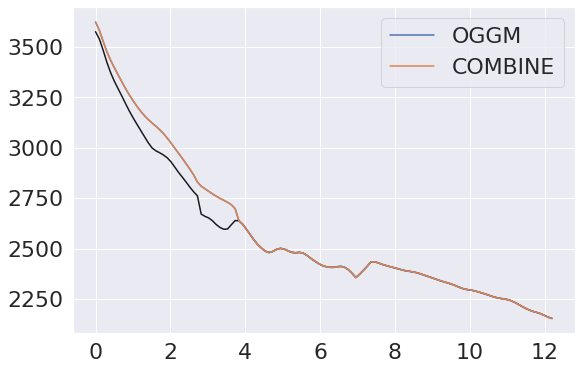

In [23]:
# Plot the final result:
plt.plot(distance_along_glacier, bed_h, 'k-')
plt.plot(distance_along_glacier, oggm_model.fls[-1].surface_h, label='OGGM')
plt.plot(distance_along_glacier, combine_model.fls[-1].surface_h, label='COMBINE')
plt.legend()

# Parabolic bed shape

## linear bed

In [3]:
# number of steps from bottem to top of glacier
nx = 200

# model grid spacing in m
map_dx = 100

# distance along glacier (x-axis of glacier profil plot) in km
distance_along_glacier = np.linspace(0, nx, nx) * map_dx * 1e-3

# glacier top height
glacier_top_height = 4000

# glacier bottom height
glacier_bottom_height = 0

# define linear glacier bed with zero ice thickness
bed_h = np.linspace(glacier_top_height, 0, nx)
surface_h = bed_h

# define width, so glacier bed could be created when plot is created (after creation model is ready)
shape = np.zeros(nx) + 1.
widths = np.zeros(nx) + 4.

In [4]:
oggm_fl = oggm_para_flowline(surface_h=surface_h, bed_h=bed_h,
                             bed_shape=shape, map_dx=map_dx)

combine_fl = combine_para_flowline(surface_h=surface_h, bed_h=bed_h,
                                   bed_shape=shape, map_dx=map_dx, torch_type=torch.double)

In [5]:
ELA = 3000
mb_gradient = 4

mb_model = LinearMassBalance(ELA, grad=mb_gradient)

In [6]:
# initialize the actual model
oggm_model = oggm_FluxModel(oggm_fl, mb_model=mb_model, y0=0.)

combine_model = combine_FluxFlowlineModel(combine_fl, mb_model=mb_model, y0=0.)

In [7]:
def oggm_run(year):
    oggm_model.run_until(year)

def combine_run(year):
    combine_model.run_until(year)

In [8]:
years = 200

print('OGGM: {:.2f} s\n'.format(time_fct(oggm_run, years)) +
      'COMBINE:  {:.2f} s, Iterations: {:d}\n'.format(time_fct(combine_run, years), 
                                                      combine_model.iterations))

OGGM: 1.74 s
COMBINE:  6.35 s, Iterations: 12333



In [9]:
oggm_model.name = 'OGGM'
combine_model.name = 'COMBINE'
compare_vol([oggm_model, combine_model])

                          OGGM        COMBINE
           OGGM       0.00E+00       1.21E-15
        COMBINE      -1.21E-15       0.00E+00


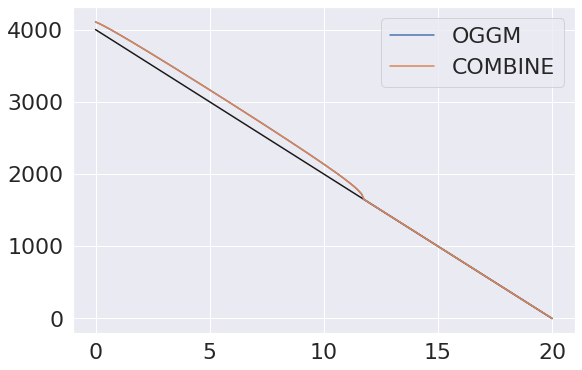

In [10]:
# Plot the final result:
plt.plot(distance_along_glacier, bed_h, 'k-')
plt.plot(distance_along_glacier, oggm_model.fls[-1].surface_h, label='OGGM')
plt.plot(distance_along_glacier, combine_model.fls[-1].surface_h, label='COMBINE')
plt.legend()

## Hintereisferner bed with constant shape

In [36]:
cfg.PATHS['working_dir'] = 'Hintereisferner_test'
gdir = oggm.GlacierDirectory('RGI60-11.00897')
fls = gdir.read_pickle('model_flowlines')
dx = fls[0].dx_meter
nx = fls[0].nx
distance_along_glacier = np.linspace(0, nx, nx) * dx * 1e-3
bed_h = fls[0].surface_h - fls[0].thick

surface_h = bed_h
shape = np.zeros(nx) + 1.

oggm_fl = oggm_para_flowline(surface_h=surface_h, bed_h=bed_h,
                             bed_shape=shape, map_dx=map_dx)

combine_fl = combine_para_flowline(surface_h=surface_h, bed_h=bed_h,
                                   bed_shape=shape, map_dx=map_dx, torch_type=torch.double)

ELA = 3000
mb_gradient = 4

mb_model = LinearMassBalance(ELA, grad=mb_gradient)

# initialize the actual model
oggm_model = oggm_FluxModel(oggm_fl, mb_model=mb_model, y0=0.)

combine_model = combine_FluxFlowlineModel(combine_fl, mb_model=mb_model, y0=0.)

def oggm_run(year):
    oggm_model.run_until(year)

def combine_run(year):
    combine_model.run_until(year)

In [37]:
years = 200

print('OGGM: {:.2f} s\n'.format(time_fct(oggm_run, years)) +
      'COMBINE:  {:.2f} s, Iterations: {:d}\n'.format(time_fct(combine_run, years), 
                                                      combine_model.iterations))

OGGM: 0.61 s
COMBINE:  2.47 s, Iterations: 4943



In [38]:
oggm_model.name = 'OGGM'
combine_model.name = 'COMBINE'
compare_vol([oggm_model, combine_model])

                          OGGM        COMBINE
           OGGM       0.00E+00       8.67E-19
        COMBINE      -8.67E-19       0.00E+00


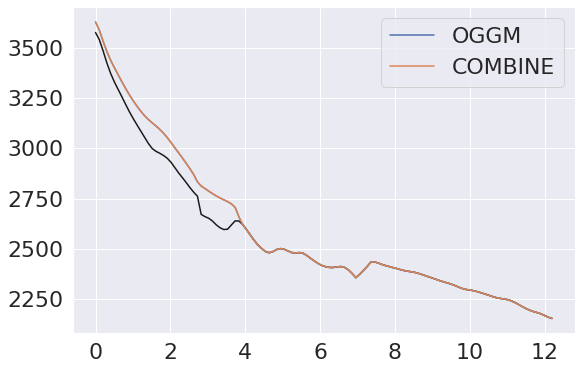

In [39]:
# Plot the final result:
plt.plot(distance_along_glacier, bed_h, 'k-')
plt.plot(distance_along_glacier, oggm_model.fls[-1].surface_h, label='OGGM')
plt.plot(distance_along_glacier, combine_model.fls[-1].surface_h, label='COMBINE')
plt.legend()

## Hintereisferner with shanging shape factor

In [40]:
cfg.PATHS['working_dir'] = 'Hintereisferner_test'
gdir = oggm.GlacierDirectory('RGI60-11.00897')
fls = gdir.read_pickle('model_flowlines')
dx = fls[0].dx_meter
nx = fls[0].nx
distance_along_glacier = np.linspace(0, nx, nx) * dx * 1e-3
bed_h = fls[0].surface_h - fls[0].thick

surface_h = bed_h
shape = np.where(np.isnan(fls[0].bed_shape),
                 np.nanmin(fls[0].bed_shape),
                 fls[0].bed_shape)

oggm_fl = oggm_para_flowline(surface_h=surface_h, bed_h=bed_h,
                             bed_shape=shape, map_dx=map_dx)

combine_fl = combine_para_flowline(surface_h=surface_h, bed_h=bed_h,
                                   bed_shape=shape, map_dx=map_dx, torch_type=torch.double)

ELA = 3000
mb_gradient = 4

mb_model = LinearMassBalance(ELA, grad=mb_gradient)

# initialize the actual model
oggm_model = oggm_FluxModel(oggm_fl, mb_model=mb_model, y0=0.)

combine_model = combine_FluxFlowlineModel(combine_fl, mb_model=mb_model, y0=0.)

def oggm_run(year):
    oggm_model.run_until(year)

def combine_run(year):
    combine_model.run_until(year)

In [41]:
years = 200

print('OGGM: {:.2f} s\n'.format(time_fct(oggm_run, years)) +
      'COMBINE:  {:.2f} s, Iterations: {:d}\n'.format(time_fct(combine_run, years), 
                                                      combine_model.iterations))

OGGM: 0.59 s
COMBINE:  2.43 s, Iterations: 4784



In [42]:
oggm_model.name = 'OGGM'
combine_model.name = 'COMBINE'
compare_vol([oggm_model, combine_model])

                          OGGM        COMBINE
           OGGM       0.00E+00       1.11E-16
        COMBINE      -1.11E-16       0.00E+00


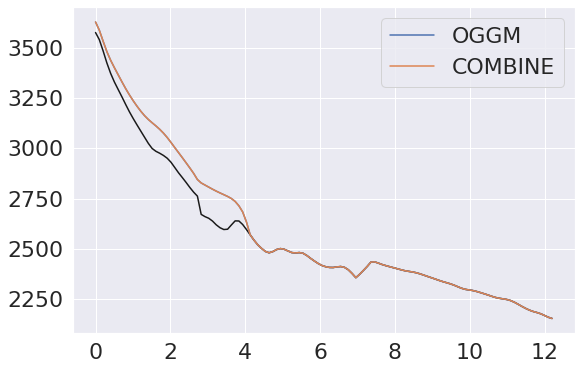

In [43]:
# Plot the final result:
plt.plot(distance_along_glacier, bed_h, 'k-')
plt.plot(distance_along_glacier, oggm_model.fls[-1].surface_h, label='OGGM')
plt.plot(distance_along_glacier, combine_model.fls[-1].surface_h, label='COMBINE')
plt.legend()

# Trapezoidal bed shape

In [44]:
# number of steps from bottem to top of glacier
nx = 200

# model grid spacing in m
map_dx = 100

# distance along glacier (x-axis of glacier profil plot) in km
distance_along_glacier = np.linspace(0, nx, nx) * map_dx * 1e-3

# glacier top height
glacier_top_height = 4000

# glacier bottom height
glacier_bottom_height = 0

# define linear glacier bed with zero ice thickness
bed_h = np.linspace(glacier_top_height, 0, nx)
surface_h = bed_h

# define width, so glacier bed could be created when plot is created (after creation model is ready)
shape = np.zeros(nx) + 1.
widths = np.zeros(nx) + 4.

In [46]:
oggm_fl = oggm_trap_flowline(surface_h=surface_h, bed_h=bed_h,
                             lambdas=shape, widths=widths, map_dx=map_dx)

combine_fl = combine_trap_flowline(surface_h=surface_h, bed_h=bed_h,
                                   lambdas=shape, widths=widths, map_dx=map_dx, torch_type=torch.double)

In [47]:
ELA = 3000
mb_gradient = 4

mb_model = LinearMassBalance(ELA, grad=mb_gradient)

In [48]:
# initialize the actual model
oggm_model = oggm_FluxModel(oggm_fl, mb_model=mb_model, y0=0.)

combine_model = combine_FluxFlowlineModel(combine_fl, mb_model=mb_model, y0=0.)

In [49]:
def oggm_run(year):
    oggm_model.run_until(year)

def combine_run(year):
    combine_model.run_until(year)

In [50]:
years = 200

print('OGGM: {:.2f} s\n'.format(time_fct(oggm_run, years)) +
      'COMBINE:  {:.2f} s, Iterations: {:d}\n'.format(time_fct(combine_run, years), 
                                                      combine_model.iterations))

OGGM: 1.62 s
COMBINE:  5.62 s, Iterations: 10582



In [51]:
oggm_model.name = 'OGGM'
combine_model.name = 'COMBINE'
compare_vol([oggm_model, combine_model])

                          OGGM        COMBINE
           OGGM       0.00E+00       2.78E-15
        COMBINE      -2.78E-15       0.00E+00


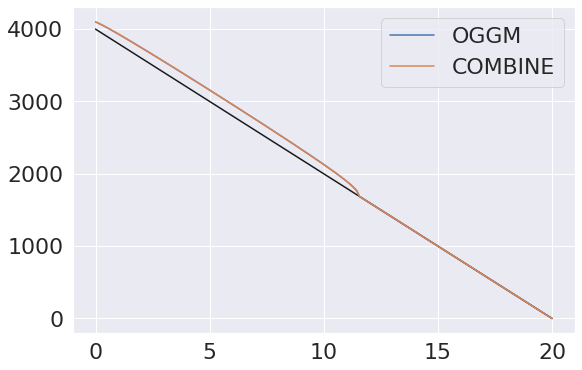

In [52]:
# Plot the final result:
plt.plot(distance_along_glacier, bed_h, 'k-')
plt.plot(distance_along_glacier, oggm_model.fls[-1].surface_h, label='OGGM')
plt.plot(distance_along_glacier, combine_model.fls[-1].surface_h, label='COMBINE')
plt.legend()